In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# !pip install --upgrade pip
# !pip install -U torch
# !pip install -U torchvision
# !pip install -U scipy
# !pip install -U scikit-learn
!pip install fastai
!pip install efficientnet_pytorch

    100% |████████████████████████████████| 235kB 99.7MB/s eta 0:00:01
    100% |████████████████████████████████| 30.9MB 69.3MB/s ta 0:00:011% |██▏                             | 2.1MB 85.9MB/s eta 0:00:01██▌                    | 11.1MB 96.0MB/s eta 0:00:01MB/s eta 0:00:01███████████████▋           | 19.9MB 91.5MB/s eta 0:00:01████████████████████████       | 24.1MB 92.6MB/s eta 0:00:01ta 0:00:01
    100% |████████████████████████████████| 20.4MB 81.0MB/s ta 0:00:011MB 94.2MB/s eta 0:00:01         | 7.5MB 93.9MB/s eta 0:00:01MB/s eta 0:00:01MB/s eta 0:00:01
    100% |████████████████████████████████| 3.2MB 99.2MB/s eta 0:00:01�████████████████▊   | 2.8MB 103.8MB/s eta 0:00:01
    100% |████████████████████████████████| 2.1MB 100.2MB/s ta 0:00:01�█████████████████████▉  | 2.0MB 102.8MB/s eta 0:00:01
    100% |████████████████████████████████| 184kB 100.9MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 79.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for nvidia-ml-py3 .

  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for efficientnet-pytorch ... done
  Stored in directory: /home/ma-user/.cache/pip/wheels/8d/45/85/402649f63b846905dff0425647ac65329634bf5bd0b84e20f7
Successfully built efficientnet-pytorch
You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.learner import model_meta
from efficientnet_pytorch import EfficientNet
import moxing as mox

mox.file.shift('os', 'mox')

INFO:root:Using MoXing-v1.13.0-de803ac9
INFO:root:Using OBS-Python-SDK-3.1.2


In [5]:
%reload_ext autoreload

In [3]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--data_url', type=str, default='./garbage_classify',
                    help=' path of dataset')
parser.add_argument('--train_url', type=str, default='./output',
                    help=' path of model')
# Protect the arguments which are not parsed.
args, unparsed = parser.parse_known_args()

In [4]:
def efficient_net_b4(pretrained=True):
    model = EfficientNet.from_pretrained('efficientnet-b4')
    return nn.Sequential(model)

In [5]:
model_meta[efficient_net_b4] =  { 'cut': noop, 
                               'split': lambda m: (list(m[0][0].children())[2][7], m[1]) }
output_size = list(efficient_net_b4()[0].children())[-1].out_features
output_size

Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth" to /home/ma-user/.torch/models/efficientnet-b4-6ed6700e.pth
100%|██████████| 77999237/77999237 [00:01<00:00, 43725678.80it/s]


Loaded pretrained weights for efficientnet-b4


1000

In [4]:
model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth" to /home/ma-user/.torch/models/efficientnet-b4-6ed6700e.pth
100%|██████████| 77999237/77999237 [00:01<00:00, 44675144.85it/s]


Loaded pretrained weights for efficientnet-b4


In [ ]:
# mox.file.copy_parallel('s3://lxr/garbage_classify', './garbage_classify')

In [7]:
path = Path(args.data_url);
model_path = Path(args.train_url); model_path
data_path = path/'train_data'

In [8]:
fnames = get_image_files(data_path); fnames[:5]

[PosixPath('garbage_classify/train_data/img_12021.jpg'),
 PosixPath('garbage_classify/train_data/img_2221.jpg'),
 PosixPath('garbage_classify/train_data/img_5020.jpg'),
 PosixPath('garbage_classify/train_data/img_17680.jpg'),
 PosixPath('garbage_classify/train_data/img_11572.jpg')]

In [13]:
np.random.seed(42)
def get_labels(x): return np.loadtxt(data_path/f'{x.stem}.txt', dtype=str)[1]
data = ImageDataBunch.from_name_func(path, fnames, get_labels,
                                     ds_tfms=get_transforms(),size=224,bs=32).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (11842 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
24,6,11,23,1
Path: garbage_classify;

Valid: LabelList (2960 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,17,19,33,14
Path: garbage_classify;

Test: None

In [14]:
custom_head = nn.Linear(output_size, data.c);data.c

40

In [15]:
learn = cnn_learner(data, efficient_net_b4, custom_head = custom_head, metrics = accuracy)

Loaded pretrained weights for efficientnet-b4


In [16]:
learn.lr_find()
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 1.75 MiB (GPU 0; 15.90 GiB total capacity; 15.02 GiB already allocated; 1.88 MiB free; 3.31 MiB cached)

In [10]:
learn.fit_one_cycle(6, max_lr=slice(1e-2))
learn.save('den-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.912366,0.634097,0.807432,01:43
1,0.817137,0.629724,0.817230,01:42
2,0.596301,0.464654,0.862162,01:41
3,0.399325,0.437751,0.880743,01:42
4,0.258541,0.379451,0.892230,01:41
5,0.185228,0.364311,0.898311,01:41


## 第二阶段训练
模型解冻

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


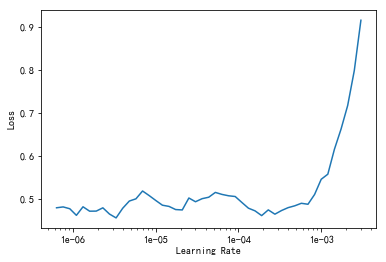

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.428161,0.366347,0.891554,02:49
1,0.440166,0.353215,0.895270,02:49
2,0.364448,0.352985,0.899662,02:48
3,0.342139,0.345469,0.901351,02:49
4,0.334396,0.345785,0.901351,02:48


In [16]:
learn.save('den-3')

## 第三阶段训练
清洗数据

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=10)

In [ ]:
from fastai.widgets import *

In [ ]:
db = (ImageList.from_folder(data_path)
                   .split_none()
                   .label_from_func(get_labels)
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.densenet201, metrics=accuracy)
learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

## 第4阶段训练
增加图像 size

In [11]:
np.random.seed(42)
data = ImageDataBunch.from_name_func(data_path, fnames, get_labels,
                                     ds_tfms=get_transforms(flip_vert=True),size=256,bs=32).normalize(imagenet_stats)
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


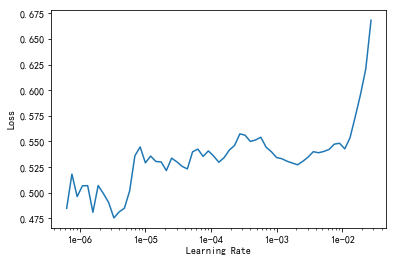

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(5, slice(1e-6,1e-4))
learn.save('den-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.534353,0.378353,0.891216,02:14
1,0.525888,0.375997,0.890878,02:13
2,0.497753,0.371321,0.894257,02:13
3,0.478577,0.372541,0.891554,02:13
4,0.471755,0.371044,0.895946,02:13


In [19]:
learn.save('den-3')

## 导出模型

In [18]:
learn.export('densenet201.pth')

In [22]:
model_path/''.ls()

[PosixPath('.Trash-1000'),
 PosixPath('fastai.ipynb'),
 PosixPath('garbage_classify'),
 PosixPath('__pycache__'),
 PosixPath('model'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('models')]

In [15]:
data_path

PosixPath('garbage_classify/train_data')

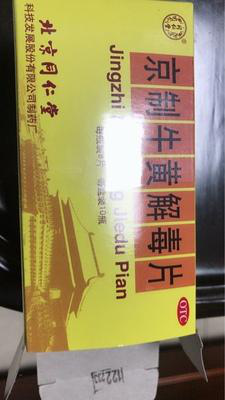

In [20]:
img = open_image(data_path/'img_19275.jpg')
img

In [20]:
path = model_path.parent; path.ls()

[PosixPath('.Trash-1000'),
 PosixPath('garbage_classify'),
 PosixPath('demo.ipynb'),
 PosixPath('__pycache__'),
 PosixPath('export.pkl'),
 PosixPath('customize_service.py'),
 PosixPath('img_645.jpg'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('models'),
 PosixPath('output')]

In [21]:
learn = load_learner(path)

In [24]:
learn.data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [40]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,pred_idx,outputs)
pred_class
learn.data.classes[pred_idx]

39 tensor(33) tensor([1.2438e-03, 3.7647e-05, 2.2686e-05, 8.6750e-05, 3.7463e-05, 3.5631e-04,
        4.8957e-04, 7.5116e-05, 1.3847e-03, 2.4516e-05, 4.4374e-05, 8.4505e-05,
        2.0767e-04, 2.4976e-02, 8.8716e-05, 1.2302e-05, 3.0770e-04, 7.0202e-05,
        1.9766e-05, 7.4685e-04, 1.4933e-04, 2.4073e-05, 2.0468e-04, 1.2864e-04,
        6.2181e-03, 7.5601e-04, 1.8625e-04, 2.9783e-03, 8.4875e-05, 4.2178e-04,
        1.1308e-04, 2.1781e-02, 5.7241e-02, 8.7857e-01, 1.1529e-05, 1.7682e-04,
        4.7219e-05, 4.0445e-04, 2.6959e-05, 1.6336e-04])


'39'

In [36]:
pred_class,pred_idx,outputs = learn.predict('')
len(outputs)

AttributeError: 'str' object has no attribute 'apply_tfms'

In [35]:
label_id_name_dict = \
            {
                "0": "其他垃圾/一次性快餐盒",
                "1": "其他垃圾/污损塑料",
                "2": "其他垃圾/烟蒂",
                "3": "其他垃圾/牙签",
                "4": "其他垃圾/破碎花盆及碟碗",
                "5": "其他垃圾/竹筷",
                "6": "厨余垃圾/剩饭剩菜",
                "7": "厨余垃圾/大骨头",
                "8": "厨余垃圾/水果果皮",
                "9": "厨余垃圾/水果果肉",
                "10": "厨余垃圾/茶叶渣",
                "11": "厨余垃圾/菜叶菜根",
                "12": "厨余垃圾/蛋壳",
                "13": "厨余垃圾/鱼骨",
                "14": "可回收物/充电宝",
                "15": "可回收物/包",
                "16": "可回收物/化妆品瓶",
                "17": "可回收物/塑料玩具",
                "18": "可回收物/塑料碗盆",
                "19": "可回收物/塑料衣架",
                "20": "可回收物/快递纸袋",
                "21": "可回收物/插头电线",
                "22": "可回收物/旧衣服",
                "23": "可回收物/易拉罐",
                "24": "可回收物/枕头",
                "25": "可回收物/毛绒玩具",
                "26": "可回收物/洗发水瓶",
                "27": "可回收物/玻璃杯",
                "28": "可回收物/皮鞋",
                "29": "可回收物/砧板",
                "30": "可回收物/纸板箱",
                "31": "可回收物/调料瓶",
                "32": "可回收物/酒瓶",
                "33": "可回收物/金属食品罐",
                "34": "可回收物/锅",
                "35": "可回收物/食用油桶",
                "36": "可回收物/饮料瓶",
                "37": "有害垃圾/干电池",
                "38": "有害垃圾/软膏",
                "39": "有害垃圾/过期药物"
            }

In [41]:
label_id_name_dict[learn.data.classes[pred_idx]]

'有害垃圾/过期药物'

In [33]:
int(pred_idx)

1